In [1]:
from db_manager import DatabaseManager


In [2]:
db_manager = DatabaseManager()

In [3]:
db_manager.create_database('university')

Database 'university' created successfully.


In [4]:
db_manager.list_databases()

['university']

In [5]:
student_schema = {
    "student_id": int,
    "name": str,
    "Phone": str,
    "age": float,
    "Branch": str
}

In [6]:
prof = {
    "prof_id": int,
    "name": str,
    "Phone": str,
    "age": float,
    "salary": int,
    "department": str
}

In [7]:
db_manager.create_table('university', 'professor', prof, order=6, search_key= "prof_id")

Table 'professor' created successfully in database 'university'.


In [8]:
db_manager.create_table('university', 'student', student_schema, order=6, search_key= "student_id")

Table 'student' created successfully in database 'university'.


In [9]:
tables_name = db_manager.list_tables('university')
tables_name

['professor', 'student']

In [10]:
table_stu= db_manager.get_table('university', 'student')
table_stu.get_all()

[]

In [11]:
rec = {
    "student_id": 9,
    "name": "xyzf",
    "Phone": "846699",
    "age": 26.0,
    "Branch": "pech Eng1"
}

### INsertion

In [12]:
table_stu.insert(rec)

Record validated successfully: {'student_id': 9, 'name': 'xyzf', 'Phone': '846699', 'age': 26.0, 'Branch': 'pech Eng1'}
Record with key '9' inserted successfully.


### Search

In [13]:
table_stu.get(9)


{'student_id': 9,
 'name': 'xyzf',
 'Phone': '846699',
 'age': 26.0,
 'Branch': 'pech Eng1'}

### Update

In [14]:
new_rec = {'student_id': 25,
 'name': 'xyzf',
 'Phone': '846',
 'age': 26.0,
 'Branch': 'pech Eng1'}

In [15]:
table_stu.update(9, new_rec)

Record validated successfully: {'student_id': 25, 'name': 'xyzf', 'Phone': '846', 'age': 26.0, 'Branch': 'pech Eng1'}
Record with key '9' updated successfully.


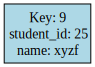

In [16]:
from IPython.display import SVG, display

dot = table_stu.data.visualize_tree()
svg_data = dot.pipe(format='svg').decode('utf-8')
display(SVG(svg_data))

### Deletion

In [17]:
table_stu.delete(9)

Record with key '9' deleted successfully.


### Range Query

In [18]:
import random
import string

def random_record_generator(schema, n):
    def random_value(data_type):
        if data_type == int:
            return random.randint(1, 100)
        elif data_type == float:
            return round(random.uniform(18.0, 60.0), 2)
        elif data_type == str:
            return ''.join(random.choices(string.ascii_letters, k=6))
        else:
            return None  # Unknown type

    records = []
    for _ in range(n):
        record = {}
        for field, field_type in schema.items():
            record[field] = random_value(field_type)
        records.append(record)
    return records

In [20]:
import pandas as pd
records = random_record_generator(student_schema, 50)

for rec in records:
    table_stu.insert(rec)
 

Record validated successfully: {'student_id': 94, 'name': 'FdFLGm', 'Phone': 'fIIQka', 'age': 34.28, 'Branch': 'uzZOGz'}
Record with key '94' inserted successfully.
Record validated successfully: {'student_id': 5, 'name': 'kGroGt', 'Phone': 'PsrxLj', 'age': 28.31, 'Branch': 'bqvdGZ'}
Record with key '5' inserted successfully.
Record validated successfully: {'student_id': 43, 'name': 'LtBjUY', 'Phone': 'zzhjtz', 'age': 54.06, 'Branch': 'JkjtsZ'}
Record with key '43' inserted successfully.
Record validated successfully: {'student_id': 29, 'name': 'qmbNea', 'Phone': 'CIpIgm', 'age': 49.96, 'Branch': 'ySfjAB'}
Record with key '29' inserted successfully.
Record validated successfully: {'student_id': 82, 'name': 'rMvhzQ', 'Phone': 'waRwqw', 'age': 35.15, 'Branch': 'BeEhuT'}
Record with key '82' inserted successfully.
Record validated successfully: {'student_id': 6, 'name': 'NdZMUI', 'Phone': 'rqfdYF', 'age': 27.68, 'Branch': 'vcGQfM'}
Record with key '6' inserted successfully.
Record validat

ValueError: Record with key '100' already exists.

In [ ]:
table_stu.range_query(63, 70)

[{'student_id': 70,
  'name': 'WzEMhz',
  'Phone': 'ykcYTY',
  'age': 24.41,
  'Branch': 'FbMtbg'}]

### Visualization

In [22]:
len(table_stu.get_all()) # insert at least 20-30 records

29

In [23]:
dot = table_stu.data.visualize_tree()
dot.render('tree_after_insert', view=True)

'tree_after_insert.pdf'

## Performance testing